<a href="https://colab.research.google.com/github/Heuzi/NN-kNN/blob/main/backup_of_nnknn_02_10_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to use this file

Run everything in "Module definitions" section. This will set up all the classes needed.

Run the section "pydml" to access knn using other distance metric learning algorithms.

Run a subsection in "Data Sets" section to load the data set you want.

If the data set is a regression data set, run "Standardize Regression Data sets"

Run either "classification" or "Regression".
Notice that at the beginning of these two sections, there are settings you can tune for NN-kNN

Run "Result look up" section to check results.

Good luck, future Ye or whoever reads this.

--- Past Ye

This is a backup file, that should work for all experiments described in the paper: "Combining Interpretability and Neural Network Power: A Neural Network based K-Nearest Neighbor Algorithm"

##Important settings for best performance

Regularizer like L2 REGULARIZATION WILL LOWER THE ACCURACY OF NNKNN!

default case activation layer's bias needs to be carefully set.

```
    # self.bias = torch.nn.Parameter(torch.ones(num_cases) * num_features/2 )
    self.bias = torch.nn.Parameter(torch.ones(num_cases) )
```
These two choices depends on the number of features you have. If you have too many features and the feature distances are big, they might reduce your case activation to 0 and therefore no learning can occur. In that case, use the first one.


#Module definitions

Boring imports

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


##New Feature Act Layer

In [ ]:
dropout_rate = 0.5

In [ ]:
class FeatureActivationLayer(torch.nn.Module):
  '''
    measures the feature distance/activation between query and all cases
  '''
  def __init__(self, num_features, num_cases, cases, hidden_layers = False):
    super().__init__()
    #we assume feature weight sharing between segments
    self.feature_matrix = cases
    self.f1weight = torch.nn.Parameter(torch.ones(num_features))
    # self.activation_func = torch.relu

    self.hidden_layers = hidden_layers
    hidden_dim = num_features * 2
    extract_dim = num_features
    self.layer1 = nn.Linear(num_features, hidden_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=dropout_rate)
    self.layer2 = nn.Linear(hidden_dim,extract_dim)

    # self.layer3 = nn.Linear(num_features*3, num_features*2)
    # self.layer4 = nn.Linear(num_features*2, extract_dim)
  def forward(self, query, cases):
    '''
      input: (m+1) cases * n features; where the first case is the query
      output: m* n feature activations
    '''
    if self.hidden_layers:
      query = self.layer1(query)
      query = self.relu(query)
      query = self.dropout(query)
      query = self.layer2(query)
      query = self.relu(query)
      # query = self.layer3(query)
      # query = self.relu(query)
      # query = self.layer4(query)
      # query = self.relu(query)

      cases = self.layer1(cases)
      cases = self.relu(cases)
      cases = self.dropout(cases)
      cases = self.layer2(cases)
      cases = self.relu(cases)
      # cases = self.layer3(cases)
      # cases = self.relu(cases)
      # cases = self.layer4(cases)
      # cases = self.relu(cases)

    query = query.unsqueeze(1)

    # print("cool")
    # print(query.shape)
    # print(query)
    # print((query*self.f1weight).shape)
    # print((query*self.f1weight))
    # print(self.f1weight.shape)
    # print(self.f1weight)
    # print((cases*self.f1weight).shape)
    # print((cases*self.f1weight))
    # print((query*self.f1weight - cases*self.f1weight).shape)
    # print((query*self.f1weight - cases*self.f1weight))
    #the following utilize pytorch tensor broadcasting functionality
    #if the below line does not make sense, uncomment lines above to debug and check values
    return (query*self.f1weight - cases*self.f1weight)**2

###Old Feature Activation Layer
Deprecated

In [ ]:
class OldFeatureActivationLayer(torch.nn.Module):
  '''
    measures the feature distance/activation between query and all cases
  '''
  def __init__(self, num_features, num_cases, weight_sharing_within_segment=False, weight_sharing_between_segment= False, hidden_layers = False):
    super().__init__()
    self.weight_sharing_between_segment = weight_sharing_between_segment
    if self.weight_sharing_between_segment:
      self.segments = torch.nn.ModuleList([OldFeatureActivationSegment(num_features, weight_sharing_within_segment, hidden_layers)])
    else:
      self.segments = torch.nn.ModuleList([OldFeatureActivationSegment(num_features, weight_sharing_within_segment, hidden_layers) for _ in range(num_cases)])
    # feature activation layer should not have its own activation function,
    # instead, it should just reuse feature activation segments' activation function, which is called by OldFeatureActivationSegment
    # self.activation_func = torch.nn.Identity()
  def set_f_weight_for_all_segments(self, f):
    for segment in self.segments:
      segment.set_f1(f)
      segment.set_f2(f)
  def freeze_f_weight_for_all_segments(self):
    for segment in self.segments:
      segment.freeze_f1()
      segment.freeze_f2()
  def forward(self, query, cases):
    '''
      input: (m+1) cases * n features; where the first case is the query
      output: m* n feature activations
    '''
    if self.weight_sharing_between_segment:
      #only uses the first segment through out.
      return torch.stack([self.segments[0](query, case) for case in cases], dim=1)
    return torch.stack([segment(query, case) for segment, case in zip(self.segments, cases)], dim=1) ###OMG, colab is a great programmer.

###Old Feature Activation Segment

Deprecated

assume there are m cases, n features for each case

In [ ]:
class OldFeatureActivationSegment(torch.nn.Module):
  '''
    measures the feature distance/activation between two cases

    two features connect to one feature activation node

    multiple feature activation layer only connects to one case node

    num_features: number of features that f1 or f2 contains. f1 is a vector of features for one case.
  '''
  def __init__(self, num_features, weight_sharing=False, hidden_layers = False):
    super().__init__()
    self.weight_sharing = weight_sharing
    ## IMPORTANT DESIGN DECISION:: start weights and biases with ones instead of randoms.
    self.f1weight = torch.nn.Parameter(torch.ones(num_features))
    self.f2weight = torch.nn.Parameter(torch.ones(num_features))
    if weight_sharing:
      self.f2weight = self.f1weight
    #it does not make sense that the bias is non-zero.
    # self.bias = torch.nn.Parameter(torch.zeros(num_features))
    # self.activation_func = torch.nn.Identity()
    self.activation_func = torch.relu

    self.hidden_layers = hidden_layers
    hidden_dim = num_features * 2
    extract_dim = num_features
    self.layer1 = nn.Linear(num_features, hidden_dim)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_dim, extract_dim)

  # maybe not needed
  # def set_activation_func(self, activation_function):
  #   self.activation_func = activation_function

  def set_f1(self, f1):
    self.f1weight = f1

  def set_f2(self, f2):
    self.f2weight = f2

  def freeze_f1(self):
    self.f1weight.requires_grad = False

  def freeze_f2(self):
    self.f2weight.requires_grad = False

  def forward(self, f1, f2):
    '''
      input: f1 and f2, are both feature vectors of a case, shape n.
      output: feature activation, shape n.
    '''
    if self.hidden_layers:
      f1 = self.layer1(f1)
      f1 = self.relu(f1)
      f1 = self.layer2(f1)
      f1 = self.relu(f1)

      f2 = self.layer1(f2)
      f2 = self.relu(f2)
      f2 = self.layer2(f2)
      f2 = self.relu(f2)


    # return self.activation_func(self.f1weight * f1 + self.f2weight * f2 + self.bias)
    # IMPORTANT DESIGN DECISION:: minus makes more sense here as in standard k-NN.
    # feature_distance = self.f1weight * f1 - self.f2weight * f2
    # feature_distance = (self.f1weight * f1 - self.f2weight * f2) ** 2
    # feature_distance = torch.abs(self.f1weight * f1 - self.f2weight * f2)
    feature_distance = (self.f1weight * f1 - self.f2weight * f2) ** 2
    # feature_distance = torch.abs(self.f1weight * f1 - self.f2weight * f2)
    # return self.activation_func(feature_distance + self.bias)
    return self.activation_func(feature_distance)

##Case Activation Layer

IMPORTANT.
```
    # self.bias = torch.nn.Parameter(torch.ones(num_cases) * num_features/2 )
    self.bias = torch.nn.Parameter(torch.ones(num_cases) )
```
These two choices depends on the number of features you have. If you have too many features, may use the first one.


In [ ]:
class CaseActivationLayer(torch.nn.Module):
  '''
    measures the activation of a case given some feature activations

    input:
      m* n feature activations
    output:
      m case activations
  '''
  def __init__(self, num_features, num_cases, weight_sharing=False):
    super().__init__()
    self.weight_sharing = weight_sharing
    self.fa_weight = torch.nn.Parameter(torch.ones((num_cases, num_features)))
    if weight_sharing:
      self.fa_weight = torch.nn.Parameter(torch.ones(num_features))

    # self.bias = torch.nn.Parameter(torch.ones(num_cases) * num_features/2 )
    self.bias = torch.nn.Parameter(torch.ones(num_cases) )
  def forward(self,input):
    '''
      input: m*n feature activations
      output: m case activations
    '''
    input = - torch.sum(input * F.leaky_relu(self.fa_weight), dim=2) + self.bias
    ## we don't want negative values in activations
    ## they will mess up our top case selections because if the tops are negatives
    ## then the filled 0s are actually bigger.
    input = F.sigmoid(input)
    # input = torch.relu(input)
    return input

##Top Case Selection Layer

In [ ]:
# prompt: define a class named TopCaseLayer inherited from torch.nn.Module. This class is used to select the top k activations of an input tensor (m case activations), and output a tensor of the same shape but only keep the top k activations, and other tensors zeroed out

class TopCaseLayer(torch.nn.Module):
  def __init__(self, k):
    super().__init__()
    self.k = k
    self.training = True

  def forward(self, input):
    ##no behavior during training because we want to train for all.
    if self.training:
      return input
    '''
      input: m case activations
      output: m case activations, the top k activations are kept and others are zeroed out
    '''
    # print(input)
    vals, idx = torch.topk(input, self.k)

    #if any of the vals is zero, it will mess things up, reverse them so that they becomes positive.

    # print(input.shape)
    # print(idx.shape)
    # print(vals.shape)
    # print("huh??")
    output = torch.zeros_like(input).scatter_(1,idx, vals)
    #replace output values such that the top k is kept


    # output[:, idx] = vals
    return output


##Class Activation Layer

In [ ]:
# class ClassActivationLayer(torch.nn.Module):
#   '''
#     measures the activation of a class given some case activations

#     input:
#       m case_activations
#     output:
#       l class_activations
#   '''
#   def __init__(self, num_cases, case_labels, weight_sharing=False):
#     super().__init__()
#     self.constraints = []
#     self.case_labels = case_labels
#     self.num_classes = torch.unique(case_labels).shape[0]
#     # self.weight_sharing = weight_sharing
#     #weight sharing doesn't make sense here, some cases shouldn't contribute to a class while some should
#     # they should not share weights.
#     self.ca_weight = torch.nn.Parameter(torch.ones((num_cases, self.num_classes))) ## should I use randn here?
#     # self.ca_weight = torch.nn.Parameter(torch.rand((num_cases, self.num_classes)))
#     # if weight_sharing:
#     #   self.ca_weight = torch.nn.Parameter(torch.randn(num_cases))
#     # self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
#     self.bias = torch.nn.Parameter(torch.zeros(self.num_classes))

#     print("self.ca_weight.shape", self.ca_weight.shape)
#   ##NOTE:: the following three constrain uses for loop, may not be the most efficient
#   def case_class_constrain_v1(self):
#     '''
#       ensures that each case only positively activates their correct class label.
#     '''
#     self.constraints.append("case_pos_class")


#   ##NOTE:: if used, this should be called before the constrain_v1()
#   def cases_share_weight_on_same_class(self):
#     '''
#       all cases of the same class share one weight for that class.
#     '''
#     self.constraints.append("case_share_weight_on_same_class")


#   def case_class_constrain_v2(self):
#     '''
#       ensures that each case does not contribute to incorrect classes.
#     '''
#     self.constraints.append("case_no_contribute_to_wrong_class")
#   def case_class_constrain_v3(self):
#     '''
#       ensures that each case only negatively contribute to incorrect classes.
#     '''
#     #TODO, needs revamping
#     #The weight manipulation should only happen during forward()
#     raise ValueError("error, needs revamping")
#     for i in range(self.ca_weight.shape[0]):
#       for j in range(self.ca_weight.shape[1]):
#         if j != case_labels[i]:
#           self.ca_weight[i][j] = 0 - torch.relu(self.ca_weight[i][j])
#   def forward(self, ca):
#     constrained_weight = self.ca_weight.clone().detach()
#     for i in range(constrained_weight.shape[0]):
#       for j in range(constrained_weight.shape[1]):
#         if(j == self.case_labels[i]):
#           if("case_pos_class" in self.constraints):
#             constrained_weight[i][j] = torch.relu(self.ca_weight[i][j])
#         else: # j != case_labels[i]
#           if("case_no_contribute_to_wrong_class" in self.constraints):
#             constrained_weight[i][j] = torch.zeros(1)
#     return torch.matmul(ca, constrained_weight) + self.bias #matrix multiplication will handle 1 dimension vector property

The below code is another implementation of ClassActivationLayer which use mask to reduce the amount of computations during the forward.

In [ ]:
class ClassActivationLayer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      l class_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.case_labels = case_labels
    self.num_classes = torch.unique(case_labels).shape[0]
    # self.weight_sharing = weight_sharing
    #weight sharing doesn't make sense here, some cases shouldn't contribute to a class while some should
    # they should not share weights.
    self.ca_weight = torch.nn.Parameter(torch.ones((num_cases, self.num_classes))) ## should I use randn here?
    # self.ca_weight = torch.nn.Parameter(torch.rand((num_cases, self.num_classes)))
    # if weight_sharing:
    #   self.ca_weight = torch.nn.Parameter(torch.randn(num_cases))
    # self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    self.bias = torch.nn.Parameter(torch.ones(self.num_classes))

    # create a mask
    self.mask = torch.zeros_like(self.ca_weight)
    print("self.ca_weight.shape", self.ca_weight.shape)

  def update_mask(self):
    for i in range(self.mask.shape[0]):
      for j in range(self.mask.shape[1]):
        if(j == self.case_labels[i]):
          if("case_pos_class" in self.constraints):
            self.mask[i][j] = torch.ones(1)
        else: # j != case_labels[i]
          if("case_no_contribute_to_wrong_class" in self.constraints):
            self.mask[i][j] = torch.zeros(1)


  ##NOTE:: the following three constrain uses for loop, may not be the most efficient
  def case_class_constrain_v1(self):
    '''
      ensures that each case only positively activates their correct class label.
    '''
    self.constraints.append("case_pos_class")
    self.update_mask()


  ##NOTE:: if used, this should be called before the constrain_v1()
  def cases_share_weight_on_same_class(self):
    '''
      all cases of the same class share one weight for that class.
    '''
    self.constraints.append("case_share_weight_on_same_class")


  def case_class_constrain_v2(self):
    '''
      ensures that each case does not contribute to incorrect classes.
    '''
    self.constraints.append("case_no_contribute_to_wrong_class")
    self.update_mask()

  def case_class_constrain_v3(self):
    '''
      ensures that each case only negatively contribute to incorrect classes.
    '''
    #TODO, needs revamping
    #The weight manipulation should only happen during forward()
    raise ValueError("error, needs revamping")
    for i in range(self.ca_weight.shape[0]):
      for j in range(self.ca_weight.shape[1]):
        if j != case_labels[i]:
          self.ca_weight[i][j] = 0 - torch.relu(self.ca_weight[i][j])
  def forward(self, ca):
    constrained_weight = self.mask * torch.relu(self.ca_weight)
    return torch.matmul(ca, constrained_weight) + self.bias #matrix multiplication will handle 1 dimension vector property

##Regression Activation Layer

In [ ]:
class CustomSoftmaxLayer(torch.nn.Module):
  def __init__(self):
    super(CustomSoftmaxLayer, self).__init__()

  def forward(self, x):
    total = torch.sum(x, dim=1, keepdim=True)
    softmax_output = x / (total + 1e-10)

    ##IMPORTANT, cannot use the softmax version below, because of dividing by 0 problem.

    # # Apply the exponential function to the input tensor
    # exp_x = torch.exp(x)

    # # Apply a mask to set the output to 0 where the input is 0
    # mask = (x != 0).float()  # Create a binary mask (1 where x is not 0, 0 where x is 0)

    # # Apply the mask to the output
    # softmax_output = exp_x * mask

    # # Normalize the output by dividing by the sum along the same axis
    # softmax_output = softmax_output / softmax_output.sum(dim=1, keepdim=True)

    return softmax_output

In [ ]:
# prompt: Build a regression activation layer just like the class activation layer above, but for the purpose of regression now
## right now this is essentially a linear layer, but somehow it's a lot slower than a linear layer,
class RegressionActivation_1_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
    self.ca_weight = torch.nn.Parameter(torch.randn((num_cases, self.num_classes))) ## should I use randn here?
    self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    print("self.ca_weight.shape", self.ca_weight.shape)
  def forward(self, ca):
    ##IMPORTANT, newly added "* case_labels" here, so that case labels is now considered in
    ##the last layer of NN-k-NN regressor.
    # print("debugg msaafasdf")
    # print(ca.shape)
    # print(self.ca_weight.shape)
    # print(self.case_labels.shape)
    # print((torch.matmul(ca * self.case_labels, self.ca_weight)).shape)
    return torch.matmul(ca, self.ca_weight) + self.bias

In [ ]:
class RegressionActivation_2_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
    self.ca_weight = torch.nn.Parameter(torch.ones((num_cases, self.num_classes))) ## should I use randn here?
    self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    print("self.ca_weight.shape", self.ca_weight.shape)
  def forward(self, ca):
    return torch.matmul(ca* self.case_labels, self.ca_weight) + self.bias

In [ ]:
class RegressionActivation_3_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
  def forward(self, ca):
    return torch.matmul(ca, self.case_labels) #+ self.bias

In [ ]:
ca = torch.Tensor([1 , 0.5, 0.3])

In [ ]:
ca.shape

torch.Size([3])

In [ ]:
case_labels = torch.Tensor([0,2,2])

In [ ]:
torch.matmul(ca, case_labels)

tensor(1.6000)

In [ ]:
class RegressionActivation_4_Layer(torch.nn.Module):
  '''
    measures the activation of a class given some case activations

    input:
      m case_activations
    output:
      1 regression_activations
  '''
  def __init__(self, num_cases, case_labels, weight_sharing=False):
    super().__init__()
    self.constraints = []
    self.num_classes = 1
    self.case_labels = case_labels
    self.ca_weight = torch.nn.Parameter(torch.tensor(case_labels).reshape(num_cases, self.num_classes)) ## should I use randn here?
    self.bias = torch.nn.Parameter(torch.randn(self.num_classes))
    print("self.ca_weight.shape", self.ca_weight.shape)
  def forward(self, ca):
    ##IMPORTANT, newly added "* case_labels" here, so that case labels is now considered in
    ##the last layer of NN-k-NN regressor.
    # print("debugg msaafasdf")
    # print(ca.shape)
    # print(self.ca_weight.shape)
    # print(self.case_labels.shape)
    # print((torch.matmul(ca * self.case_labels, self.ca_weight)).shape)
    return torch.matmul(ca, self.ca_weight) + self.bias

In [ ]:
a = torch.ones((100, 8))
b = torch.ones((1548, 8))
c = torch.ones((1))

In [ ]:
# a-b

In [ ]:
# (b*b).shape

In [ ]:
# (a*b).shape

In [ ]:
# torch.matmul(a, b).shape

In [ ]:
# torch.matmul(a, b)

In [ ]:
# torch.matmul(a, b) + c

## NN-k-NN

In [ ]:
import torch.nn.functional as F


class NN_k_NN(torch.nn.Module):
  def __init__(self, cases, case_labels,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing, hidden_layers= False):
    super().__init__()
    self.cases = cases
    num_cases = cases.shape[0]
    num_features = cases.shape[1]
    # num_classes = torch.unique(case_labels).shape[0] # len(set(case_labels))
    ##IMPORTANT:: CHECK THE WEIGHT_SHARING PARAMETERS!!
    # self.fa_layer = FeatureActivationLayer(num_features, num_cases,
    #                                        weight_sharing_within_segment= fa_weight_sharing_within_segment,
    #                                        weight_sharing_between_segment= fa_weight_sharing_between_segment,
    #                                        hidden_layers = hidden_layers)
    self.fa_layer = FeatureActivationLayer(num_features, num_cases, self.cases, hidden_layers = hidden_layers)

    self.ca_layer = CaseActivationLayer(num_features, num_cases,
                                        weight_sharing= ca_weight_sharing)
    self.top_case_enabled = top_case_enabled
    self.selection_layer = TopCaseLayer(top_k)
    self.class_layer = ClassActivationLayer(num_cases, case_labels,
                                            weight_sharing=class_weight_sharing)
    ## more preprocessing here needed to tie each case to their correct class
    ## only one is turned on right now for testing purpose.
    self.class_layer.case_class_constrain_v1()
    self.class_layer.case_class_constrain_v2()

    self.ca_dropout = torch.nn.Dropout(p=0.5)

  def forward(self, query):
    #repeat query so that it has the same shape as self.cases
    # query = query.repeat(self.cases.shape[0], 1)
    #no need to repeat the query, fa_layer's forward will handle it.
    feature_activations = self.fa_layer(query, self.cases)
    # print("feature_activations.shape", feature_activations.shape)
    ##tie the fa_segments with corresponding case in ca layer
    #each segment should only tie to one case in ca_layer
    case_activations = self.ca_layer(feature_activations)
    # print("case_activations" , case_activations.shape)
    #uncomment to enable topk
    if self.top_case_enabled:
      case_activations = self.selection_layer(case_activations)

    # if self.training:
    #   case_activations = self.ca_dropout(case_activations)
      # # print("dropout")
      #==========#
      # expect the case_activations has the shape of (query_number, case_numer)
      # expect the query has the shape of (batch_size, feature_size)
      # expect the cases has the shape of (case_number, feature_size)
      # dquery = query.unsqueeze(1)
      # dcases = self.cases.unsqueeze(0)
      # difference = torch.sum(dquery - dcases, dim=-1)
      # masks = torch.where(difference == 0, 0., 1.)
      # # print("masks.shape", masks.shape)
      # # print("case_activations.shape", case_activations.shape)
      # case_activations = case_activations * masks
      # # print("case_activations.shape", case_activations.shape)


    # print("case_activations" , case_activations.shape)
    class_ativations = self.class_layer(case_activations)
    # print("class_ativations.shape", class_ativations.shape)

    # Softmax activation for classification
    # output = F.softmax(class_ativations, dim=1)
    output = class_ativations

    # Get the class predictions (class with the highest probability)
    ## TODO:: need debug here, am I using the right dim?
    _, predicted_class = torch.max(output, 1)

    return case_activations, output, predicted_class
    # return self.class_layer(ca)

##NN-k-NN regression

In [ ]:
import torch.nn.functional as F

##IMPORTANT, cannot use top case selection layer here like we do in for classification.
## it has to be either enabled or disabled the whole time.
class NN_k_NN_regression(torch.nn.Module):
  def __init__(self, cases, case_labels,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing, hidden_layers= False):
    super().__init__()
    self.cases = cases
    num_cases = cases.shape[0]
    num_features = cases.shape[1]
    # num_classes = torch.unique(case_labels).shape[0] # len(set(case_labels))
    ##IMPORTANT:: CHECK THE WEIGHT_SHARING PARAMETERS!!
    # self.fa_layer = FeatureActivationLayer(num_features, num_cases,
    #                                        weight_sharing_within_segment= fa_weight_sharing_within_segment,
    #                                        weight_sharing_between_segment= fa_weight_sharing_between_segment,
    #                                        hidden_layers = hidden_layers)
    self.fa_layer = FeatureActivationLayer(num_features, num_cases, self.cases, hidden_layers = hidden_layers)
    self.ca_layer = CaseActivationLayer(num_features, num_cases,
                                        weight_sharing= ca_weight_sharing)
    self.top_case_enabled = top_case_enabled
    self.selection_layer = TopCaseLayer(top_k)

    self.ca_dropout = torch.nn.Dropout(p=0.5)

    self.softmax = CustomSoftmaxLayer()
    # self.softmax = torch.nn.Softmax(dim=1)

    self.class_layer = RegressionActivation_3_Layer(num_cases, case_labels,weight_sharing=class_weight_sharing)
    # self.class_layer = torch.nn.Linear(num_cases, 1)


  def forward(self, query):
    feature_activations = self.fa_layer(query, self.cases)
    # print("feature_activations.shape", feature_activations.shape)
    ##tie the fa_segments with corresponding case in ca layer
    #each segment should only tie to one case in ca_layer
    case_activations = self.ca_layer(feature_activations)
    # print("case_activations" , case_activations.shape)
    #uncomment to enable topk
    if self.top_case_enabled:
      case_activations = self.selection_layer(case_activations)
    # print("case_activations1" , torch.sum(case_activations, dim= 1))

    # if self.training:
    #   # case_activations = self.ca_dropout(case_activations)
    #   # print("dropout")
    #   # ==========#
    #   # expect the case_activations has the shape of (query_number, case_numer)
    #   # expect the query has the shape of (batch_size, feature_size)
    #   # expect the cases has the shape of (case_number, feature_size)
    #   dquery = query.unsqueeze(1)
    #   dcases = self.cases.unsqueeze(0)
    #   difference = torch.sum(dquery - dcases, dim=-1)
    #   masks = torch.where(difference == 0, 0., 1.)
    #   case_activations = case_activations * masks

    case_activations = self.softmax(case_activations)


    # print("case_activations" , torch.sum(case_activations, dim= 1))
    predicted_number = self.class_layer(case_activations)

    # # Softmax activation for classification
    # output = F.softmax(class_ativations, dim=1)
    # # output = class_ativations
    # _, predicted_class = torch.max(output, 1)
    # print("predicted_class", predicted_class)
    # predicted_class = case_labels[predicted_class]
    # print("predicted_class after label lookup", predicted_class)
    ##added feature activations here in output because they might be used for adaptation
    ####VERY VERY IMPORTANT, the output format is different!!
    return feature_activations, case_activations, predicted_number


In [ ]:
# # prompt: a standard neural network with fully connected layers that has the same architecture as NN_k_NN_regression

# class nn_regression(torch.nn.Module):
#   def __init__(self, cases, case_labels,
#                fa_weight_sharing_within_segment,
#                fa_weight_sharing_between_segment,
#                ca_weight_sharing,
#                top_case_enabled, top_k,
#                class_weight_sharing):
#     super().__init__()
#     ##WIP
#     self.cases = torch.nn.parameters(torch.randn_like(cases))
#     num_cases = cases.shape[0]
#     num_features = cases.shape[1]
#     # num_classes = torch.unique(case_labels).shape[0] # len(set(case_labels))
#     ##IMPORTANT:: CHECK THE WEIGHT_SHARING PARAMETERS!!
#     self.fa_layer = FeatureActivationLayer(num_features, num_cases, weight_sharing_within_segment= fa_weight_sharing_within_segment,
#                                            weight_sharing_between_segment= fa_weight_sharing_between_segment)
#     self.ca_layer = CaseActivationLayer(num_features, num_cases,
#                                         weight_sharing= ca_weight_sharing)
#     self.top_case_enabled = top_case_enabled
#     self.selection_layer = TopCaseLayer(top_k)
#     self.class_layer = RegressionActivationLayer(num_cases,weight_sharing=class_weight_sharing)


#   def forward(self, query):
#     feature_activations = self.fa_layer(query, self.cases)
#     ##tie the fa_segments with corresponding case in ca layer
#     #each segment should only tie to one case in ca_layer
#     case_activations = self.ca_layer(feature_activations)

#     #uncomment to enable topk
#     if self.top_case_enabled:
#       case_activations = self.selection_layer(case_activations)

#     predicted_number = self.class_layer(case_activations)

#     # # Softmax activation for classification
#     # output = F.softmax(class_ativations, dim=1)
#     # # output = class_ativations
#     # _, predicted_class = torch.max(output, 1)
#     # print("predicted_class", predicted_class)
#     # predicted_class = case_labels[predicted_class]
#     # print("predicted_class after label lookup", predicted_class)
#     ##added feature activations here in output because they might be used for adaptation
#     return feature_activations, case_activations, predicted_number


In [ ]:
def print_model_features(input_model):
  for n, p in model.named_parameters():
    print(n)
    print(p.data)

In [ ]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

#pydml

In [ ]:
pip install metric-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
import metric_learn

#Data Sets

##Classification, Fashion MNIST

In [ ]:
# prompt: load fashion mnist data set into Xs and ys
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training set and test set
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



In [ ]:
trainset[0][0]

In [ ]:
trainset[0][1]

##Classification, data sets

In [ ]:
from re import X
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_olivetti_faces
# sklearn.datasets.fetch_olivetti_faces
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler




iris = fetch_olivetti_faces()
Xs = iris['data']
ys = iris['target']
# names = iris['target_names']
# feature_names = iris['feature_names']

## fit Xs in a scaler transform, transform Xs into 0-1
# scaler = MinMaxScaler()
# Xs = scaler.fit_transform(Xs)
if Xs.shape[1] == 64: #for breast cancer
  scaler = MinMaxScaler()
  Xs = scaler.fit_transform(Xs)

Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys)

In [ ]:
Xs.shape

torch.Size([400, 4096])

In [ ]:
Xs[0]

tensor([0.3099, 0.3678, 0.4174,  ..., 0.1529, 0.1612, 0.1570])

In [ ]:
ys[0].dtype

torch.int64

## Sanity check: A normal neural network classifier.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=42, stratify=ys)

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# # Define the neural network architecture for classification
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(NeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

# # Hyperparameters
# input_size = X_train.shape[1]
# hidden_size = 64
# num_classes = torch.unique(ys).shape[0]
# learning_rate = 0.001
# batch_size = 16
# epochs = 50

# # Create DataLoader for training
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# # Initialize the model, loss function, and optimizer
# model = NeuralNet(input_size, hidden_size, num_classes)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(epochs):
#     for i, (inputs, labels) in enumerate(train_loader):
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (i + 1) % 5 == 0:
#             print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')

# # Testing the model
# model.eval()
# with torch.no_grad():
#     outputs = model(X_test_tensor)
#     _, predicted = torch.max(outputs, 1)
#     accuracy = torch.sum(predicted == y_test_tensor).item() / len(y_test_tensor)
#     print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=42, stratify=ys)

# Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = X_train
y_train_tensor = y_train
X_test_tensor = X_test
y_test_tensor = y_test

# Define the neural network architecture for classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 4, hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, num_classes)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x)

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 1024
num_classes = torch.unique(ys).shape[0]
learning_rate = 1e-5
batch_size = 16
epochs = 2000

# Create DataLoader for training
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Initialize the model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0.0
    accuracy = 0.0
    total_num = 0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        batch_size = len(labels)
        total_num += batch_size
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        _, predicted = torch.max(outputs, 1)
        accuracy += torch.sum(predicted == labels).item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # if (i + 1) % 5 == 0
    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {total_loss/(i+1):.2f} Acc: {accuracy/total_num :.2f}")
    # Testing the model
    # model.eval()
    # with torch.no_grad():
    #     outputs = model(X_test_tensor)
    #     _, predicted = torch.max(outputs, 1)
    #     accuracy = torch.sum(predicted == y_test_tensor).item() / len(y_test_tensor)
    #     print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

##Classification, Zebra

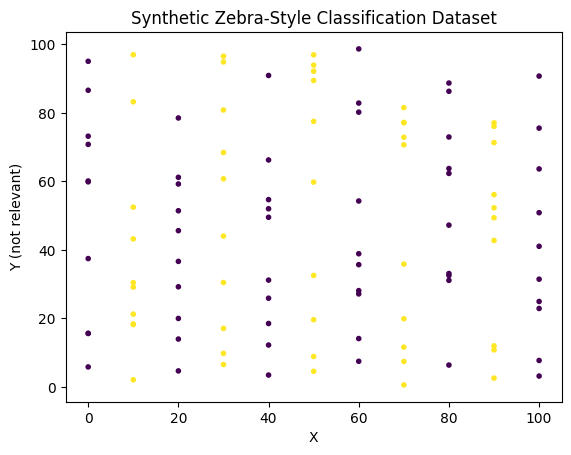

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Number of points per class
num_points = 110

# Generate alternating classes along the X-axis
x = np.linspace(0, 100, (int) (num_points/10))
#repeat X 10 times
x = np.repeat(x, 10)
y = np.random.rand(num_points)*100
labels = np.zeros(num_points)

# Assign alternating classes
labels[x%20 == 0] = 0
labels[x%20 != 0] = 1

# Plot the generated data
plt.scatter(x, y, c=labels, cmap='viridis', marker='.')
plt.title('Synthetic Zebra-Style Classification Dataset')
plt.xlabel('X')
plt.ylabel('Y (not relevant)')
# plt.colorbar(ticks=[0, 1], label='Class')
plt.show()


In [ ]:
Xs = torch.tensor(np.column_stack((x, y)), dtype=torch.float32)
ys = torch.tensor(labels, dtype=torch.long)

In [ ]:
Xs.shape

torch.Size([110, 2])

In [ ]:
ys[0]

tensor(0)

In [ ]:
ys

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

##Classification, Special Zebra

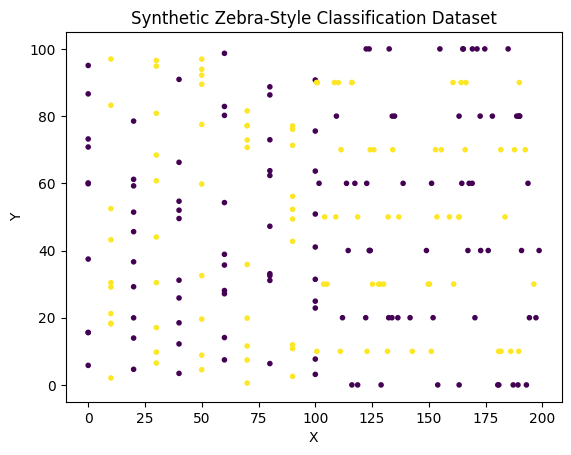

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Number of points per class
num_points = 110

# Generate alternating classes along the X-axis
x1 = np.linspace(0, 100, (int) (num_points/10))
#repeat X 10 times
x1 = np.repeat(x1, 10)
y1 = np.random.rand(num_points)*100
labels1 = np.zeros(num_points)

# Assign alternating classes
labels1[x1%20 == 0] = 0
labels1[x1%20 != 0] = 1

# Generate alternating classes along the X-axis
y2 = np.linspace(0, 100, (int) (num_points/10))
#repeat X 10 times
y2 = np.repeat(y2, 10)
x2 = 100 + np.random.rand(num_points)*100
labels2 = np.zeros(num_points)

# Assign alternating classes
labels2[y2%20 == 0] = 0
labels2[y2%20 != 0] = 1

x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
labels = np.concatenate((labels1,labels2))


# Plot the generated data
plt.scatter(x, y, c=labels, cmap='viridis', marker='.')
plt.title('Synthetic Zebra-Style Classification Dataset')
plt.xlabel('X')
plt.ylabel('Y')
# plt.colorbar(ticks=[0, 1], label='Class')
plt.show()


In [ ]:
Xs = torch.tensor(np.column_stack((x, y)), dtype=torch.float32)
ys = torch.tensor(labels, dtype=torch.long)

##Classification, Breast Cancer Dataset

In [ ]:
# prompt: load_breast_cancer

cancer = load_breast_cancer()
Xs = cancer.data
ys = cancer.target
Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys)

##Classification, BAL

Ziwei: Download the file below from https://archive.ics.uci.edu/dataset/12/balance+scale

In [ ]:
with open("balance-scale.data","r") as filef:
    bal_file = filef.readlines()

In [ ]:
Xs = []
ys = []
for line in bal_file:
    Xs.append([int(line[2]),int(line[4]),int(line[6]),int(line[8])])
    if line[0] == 'L':
        ys.append(0)
    elif line[0] == 'B':
        ys.append(1)
    elif line[0] == 'R':
        ys.append(2)

In [ ]:
Xs = torch.tensor(Xs).float()
ys = torch.tensor(ys)

##Regression, California Housing


In [ ]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing()
Xs = california_housing.data
ys = california_housing.target


In [ ]:
Xs[0]

array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ])

In [ ]:
ys[0]

4.526

In [ ]:
ys[:100]

array([4.526  , 3.585  , 3.521  , 3.413  , 3.422  , 2.697  , 2.992  ,
       2.414  , 2.267  , 2.611  , 2.815  , 2.418  , 2.135  , 1.913  ,
       1.592  , 1.4    , 1.525  , 1.555  , 1.587  , 1.629  , 1.475  ,
       1.598  , 1.139  , 0.997  , 1.326  , 1.075  , 0.938  , 1.055  ,
       1.089  , 1.32   , 1.223  , 1.152  , 1.104  , 1.049  , 1.097  ,
       0.972  , 1.045  , 1.039  , 1.914  , 1.76   , 1.554  , 1.5    ,
       1.188  , 1.888  , 1.844  , 1.823  , 1.425  , 1.375  , 1.875  ,
       1.125  , 1.719  , 0.938  , 0.975  , 1.042  , 0.875  , 0.831  ,
       0.875  , 0.853  , 0.803  , 0.6    , 0.757  , 0.75   , 0.861  ,
       0.761  , 0.735  , 0.784  , 0.844  , 0.813  , 0.85   , 1.292  ,
       0.825  , 0.952  , 0.75   , 0.675  , 1.375  , 1.775  , 1.021  ,
       1.083  , 1.125  , 1.313  , 1.625  , 1.125  , 1.125  , 1.375  ,
       1.188  , 0.982  , 1.188  , 1.625  , 1.375  , 5.00001, 1.625  ,
       1.375  , 1.625  , 1.875  , 1.792  , 1.3    , 1.838  , 1.25   ,
       1.7    , 1.93

In [ ]:
# prompt: Convert Xs and ys to tensors for pytorch

Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)


In [ ]:
Xs.shape

torch.Size([20640, 8])

In [ ]:
# prompt: downsize the data set to 10%

from sklearn.model_selection import train_test_split
_, Xs, _, ys = train_test_split(Xs, ys, test_size=0.1, random_state=42)


In [ ]:
Xs.shape

torch.Size([2064, 8])

##Regression, Abalone

In [ ]:
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from urllib import request
from io import BytesIO
import zipfile

# Download the Abalone dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
response = request.urlopen(url)
abalone_data = response.read().decode("utf-8").splitlines()

# Process and convert the data to PyTorch tensors
data = [line.strip().split(',') for line in abalone_data]
X = []
y = []

# categories = ['M', 'F', 'I']
# label_encoder = OneHotEncoder(categories=[categories])
# label_encoder.fit(data)

def encode_sex(sex):
    if sex == 'M':
        return [1, 0, 0]
    elif sex == 'F':
        return [0, 1, 0]
    elif sex == 'I':
        return [0, 0, 1]

for row in data:
    # One-hot encode the 'Sex' feature
    # sex_encoded = label_encoder.transform([[row[0]]])[0]
    sex_encoded = encode_sex(row[0])

    # Convert the row to float and extract the target variable ('Rings')
    X.append(sex_encoded + list(map(float, row[1:-1])))
    y.append(float(row[-1]))

    # # Encode the categorical 'Sex' feature
    # row[0] = label_encoder.transform([row[0]])[0]
    # # Convert the row to float and extract the target variable ('Rings')
    # X.append(list(map(float, row[:-1])))
    # y.append(float(row[-1]))

Xs = torch.tensor(X, dtype=torch.float32)
ys = torch.tensor(y, dtype=torch.float32)


##Regression, Diabetes

In [ ]:
# prompt: load the diabetes dataset from sklearn

from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
Xs = diabetes.data
ys = diabetes.target
# prompt: convert Xs and ys to float tensor

Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)


In [ ]:
Xs[0]

tensor([ 0.0381,  0.0507,  0.0617,  0.0219, -0.0442, -0.0348, -0.0434, -0.0026,
         0.0199, -0.0176])

In [ ]:
torch.max(Xs,dim=0)

torch.return_types.max(
values=tensor([0.1107, 0.0507, 0.1706, 0.1320, 0.1539, 0.1988, 0.1812, 0.1852, 0.1336,
        0.1356]),
indices=tensor([204,   0, 367, 340, 230, 123,  58, 123,  23,  23]))

In [ ]:
ys[0]

tensor(151.)

In [ ]:
Xs.shape

torch.Size([442, 10])

In [ ]:
#

##Regression, Patchy classes

TODO

##Regression, Body Fat

Tried this data set on multiple settings. Our NN-kNN consistently perform poorly on this when compared to other methods.

https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset?resource=download

https://www.kaggle.com/code/casper6290/bodyfat-prediction#1-|-Importing-Libraries-and-Loading-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
#
df = pd.read_csv("/content/drive/MyDrive/2023 research/NN-kNN/bodyfat.csv")
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [ ]:
df.shape

(252, 15)

In [ ]:
X = df.drop(['BodyFat','Density'],axis=1)
y = df['Density']

In [ ]:
X['Bmi']=703*X['Weight']/(X['Height']*X['Height'])
X.head()

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Bmi
0,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.624460
1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.332048
2,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.666315
3,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.880784
4,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.514854


In [ ]:
X['ACratio'] = X['Abdomen']/X['Chest']
X['HTratio'] = X['Hip']/X['Thigh']
X.drop(['Weight','Height','Abdomen','Chest','Hip','Thigh'],axis=1,inplace=True)
X.head()

,Age,Neck,Knee,Ankle,Biceps,Forearm,Wrist,Bmi,ACratio,HTratio
0,23,36.2,37.3,21.9,32.0,27.4,17.1,23.624460,0.915145,1.601695
1,22,38.5,37.3,23.4,30.5,28.9,18.2,23.332048,0.886752,1.681431
2,22,34.0,38.9,24.0,28.8,25.2,16.6,24.666315,0.917537,1.664430
3,26,37.4,37.3,22.8,32.4,29.4,18.2,24.880784,0.848723,1.683860
4,24,34.4,42.2,24.0,32.2,27.7,17.7,25.514854,1.027749,1.612342


In [ ]:
z = np.abs(stats.zscore(X))

#only keep rows in dataframe with all z-scores less than absolute value of 3
X_clean = X[(z<3).all(axis=1)]
y_clean = y[(z<3).all(axis=1)]
#find how many rows are left in the dataframe
X_clean.shape

(242, 10)

In [ ]:
Xs = torch.tensor( X_clean.to_numpy(), dtype=torch.float32)
ys = torch.tensor( y_clean.to_numpy(), dtype=torch.float32)

In [ ]:
Xs[0]

tensor([23.0000, 36.2000, 37.3000, 21.9000, 32.0000, 27.4000, 17.1000, 23.6245,
         0.9151,  1.6017])

In [ ]:
ys[0]

tensor(1.0708)

##Regression, Faces

In [ ]:
Xs = np.load("part_features.npy")
ys = np.load("part_targets.npy")
#These two files are in the nn-Knn folder.

In [ ]:
Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)


In [ ]:
from sklearn.model_selection import train_test_split
_, Xs, _, ys = train_test_split(Xs, ys, test_size=0.3, random_state=42)

##Sanity Check: A standard NN for regression

In [ ]:
# prompt: a standard neural network with 3 fully connected layers for regression

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class RegressionNet(nn.Module):
#   def __init__(self, input_size):
#     super().__init__()
#     self.fc1 = nn.Linear(input_size, 32)
#     self.fc2 = nn.Linear(32, 16)
#     self.fc3 = nn.Linear(16, 1)

#   def forward(self, x):
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x


In [ ]:
# prompt: a standard neural network with 3 fully connected layers for regression

import torch
import torch.nn as nn
import torch.nn.functional as F

# class RegressionNet(nn.Module):
#   def __init__(self, input_size):
#     super().__init__()
#     self.fc1 = nn.Linear(input_size, 32)
#     self.fc2 = nn.Linear(32, 16)
#     self.fc3 = nn.Linear(16, 1)

#   def forward(self, x):
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x

class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x).squeeze()

In [ ]:
training_epochs = 100
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

# prompt: Train and test the RegressionNet on Xs and ys

k_fold = KFold(n_splits=10, shuffle = True,random_state = None)
accuracies = []

for train_index, test_index in k_fold.split(Xs):
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

  model = RegressionNet(Xs.shape[1])
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  for epoch in range(training_epochs):
    epoch_msg = True
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      # Forward pass
      outputs = model(X_train_batch)
      loss = criterion(outputs, y_train_batch)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch_msg and (epoch + 1) % 100 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{training_epochs}], Loss: {loss.item()}')

  # Testing the model
  model.eval()
  with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    print(f'Loss on the test set: {loss.item()}')
    accuracies.append(loss.item())
print(f'Average loss on the test set: {sum(accuracies)/len(accuracies)}')

For the vanilla neural network

```
Average loss on the test set: 1.3484851598739624

```

In [ ]:
outputs

In [ ]:
# prompt: print the number of parameters in model

print(sum(p.numel() for p in model.parameters()))


#Test

##Classification

newly added here.

In [ ]:
# prompt: center and scale to normalize my Xs and ys

# def standardize_tensor(input_tensor):
#     mean = input_tensor.mean()
#     std = input_tensor.std()
#     standardized_tensor = (input_tensor - mean) / std
#     return standardized_tensor

# Xs = standardize_tensor(Xs)

In [ ]:
training_epochs = 1000
learning_rate = 0.01 #0.01 #0.0001
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
hidden_layers = False

top_k = 5
class_weight_sharing = True

patience = 40

In [ ]:
# prompt: train and test my model on the Xs and ys in a 10 fold cross validation
from sklearn.neighbors import KNeighborsClassifier
# from metric_learn import LMNN,NCA

from sklearn.metrics import accuracy_score
# Split data into 10 folds
k_fold = KFold(n_splits=10, shuffle = True,random_state = None)
# Scale data, not enabled right now.
# scaler = StandardScaler()
# scaler.fit(Xs)
# Xs = scaler.transform(Xs)

# Train and test model on each fold
best_model = None
PATH = 'best_classifier_model.h5'
best_accuracy = None
best_accuracies = []
accuracies = []
knn_accuracies = []

nca_accuracies = []
klmnn_accuracies = []

count = 0

for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]

  # https://contrib.scikit-learn.org/metric-learn/supervised.html#lmnn
  # lmnn = LMNN(n_neighbors=5, learn_rate=1e-6)
  # ##TODO, change here if you need to use a different one
  # # lmnn = metric_learn.MLKR()
  # # lmnn = metric_learn.NCA(max_iter=1000)
  # lmnn.fit(X_train,y_train)
  # knn = KNeighborsClassifier(n_neighbors=5,metric=lmnn.get_metric())
  # knn.fit(X_train,y_train)
  # klmnn_accuracies.append( accuracy_score(knn.predict(X_test), y_test))

  # continue

  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

  # Train model
  model = NN_k_NN(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing,hidden_layers)
  # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=1e-5)
  # print_model_features(model)
  #Training loop
  # temp = []
  patience_counter = 0
  for epoch in range(training_epochs):
    epoch_msg = True
    # model.eval()
    # break
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      case_activations, output, predicted_class = model(X_train_batch)
      loss = criterion(output, y_train_batch)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch_msg and (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{training_epochs}], Loss: {loss.item()}')
        #inspecting the case activations
        # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
        # print(top_case_indices)
        epoch_msg = False
      # print("evaluating")
    model.eval()
    with torch.no_grad():
      case_activations, output, predicted_class = model(X_test)
      # inspecting the case activations
      # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
      # print(top_case_indices)

      # Calculate accuracy
      accuracy_temp = accuracy_score(y_test, predicted_class)
    if epoch == 0:
      best_accuracy = accuracy_temp
      torch.save(model.state_dict(), PATH)
    elif accuracy_temp > best_accuracy:
      #memorize best model
      torch.save(model.state_dict(), PATH)
      best_accuracy = accuracy_temp
      patience_counter = 0
    elif patience_counter > patience:
      model = NN_k_NN(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing)
      model.load_state_dict(torch.load(PATH))
      model.eval()
      print("patience exceeded, loading best model")
      break
    else:
      patience_counter += 1

  best_accuracies.append(best_accuracy)
  # print_model_features(model)
  # Test model
  with torch.no_grad():
    case_activations, output, predicted_class = model(X_test)

    #inspecting the case activations
    top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
    # print(top_case_indices)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted_class)
    # Add accuracy to list
    accuracies.append(accuracy)

  ##compare with a normal k-nn
  knn =  KNeighborsClassifier(n_neighbors=top_k)
  knn.fit(X_train, y_train)
  knn_accuracies.append( accuracy_score(knn.predict(X_test), y_test))

  # count += 1
  # if count == 2:
  #   break

# Print average accuracy
print("Average accuracy:", np.mean(accuracies))


self.ca_weight.shape torch.Size([99, 2])
Epoch [2/1000], Loss: 0.36109018325805664
Epoch [4/1000], Loss: 0.3528931736946106
Epoch [6/1000], Loss: 0.34503039717674255
Epoch [8/1000], Loss: 0.3374462425708771
Epoch [10/1000], Loss: 0.3300359845161438
Epoch [12/1000], Loss: 0.3226627707481384
Epoch [14/1000], Loss: 0.31520581245422363
Epoch [16/1000], Loss: 0.3076019883155823
Epoch [18/1000], Loss: 0.29984423518180847
Epoch [20/1000], Loss: 0.2919541895389557
Epoch [22/1000], Loss: 0.28395727276802063
Epoch [24/1000], Loss: 0.2758707106113434
Epoch [26/1000], Loss: 0.26770269870758057
Epoch [28/1000], Loss: 0.2594590187072754
Epoch [30/1000], Loss: 0.25115248560905457
Epoch [32/1000], Loss: 0.24280905723571777
Epoch [34/1000], Loss: 0.23446539044380188
Epoch [36/1000], Loss: 0.22615747153759003
Epoch [38/1000], Loss: 0.21790695190429688
Epoch [40/1000], Loss: 0.20971634984016418
Epoch [42/1000], Loss: 0.20157894492149353
self.ca_weight.shape torch.Size([99, 2])
patience exceeded, loading 

In [ ]:
print(np.mean(klmnn_accuracies))
print(np.mean(knn_accuracies))

nan
0.3181818181818182


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Classification with train test loader

TODO

##Standardize Regression Data sets

In [ ]:
# prompt: center and scale to normalize my Xs and ys

def standardize_tensor(input_tensor):
    mean = input_tensor.mean()
    std = input_tensor.std()
    standardized_tensor = (input_tensor - mean) / std
    return standardized_tensor

Xs = standardize_tensor(Xs)
ys = standardize_tensor(ys)

##Regression

In [ ]:
training_epochs = 1500
learning_rate = 0.01 #0.0001 #0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
hidden_layers = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40

This code below will attempt to use TPU

In [ ]:
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl
# # imports pytorch
# import torch

# # imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

# dev = xm.xla_device()
# Xs = Xs.to(dev)
# ys = ys.to(dev)


In [ ]:
# prompt: train and test my model on the Xs and ys in a 10 fold cross validation
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Split data into 10 folds
k_fold = KFold(n_splits=10, shuffle = True,random_state = None)
# Scale data, not enabled right now.
# scaler = StandardScaler()
# scaler.fit(Xs)
# Xs = scaler.transform(Xs)

# Train and test model on each fold
best_model = None
PATH = 'best_regressor_model.h5'
best_accuracy = None
best_accuracies = []
accuracies = []
top_k_average_accuracies = []
knn_accuracies = []
count = 0
for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]

  # lmnn = metric_learn.MLKR()
  # lmnn.fit(X_train,y_train)
  # knn = KNeighborsRegressor(n_neighbors=5,metric=lmnn.get_metric())
  # knn.fit(X_train,y_train)
  # knn_accuracies.append( accuracy_score(knn.predict(X_test), y_test))

  # continue

  #build a train loader with my X_train and X_test
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

  # Train model
  model = NN_k_NN_regression(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing,
                             hidden_layers)
  # model = model.to(dev)
  # print("number of parameters in model: ",len(list(model.parameters())))
  # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=1e-5)
  # print_model_features(model)
  #Training loop
  patience_counter = 0
  for epoch in range(training_epochs):
    # break # no training
    epoch_msg = True
    for X_train_batch, y_train_batch in train_loader:
      # print("training")
      ##DO NOT USE train() or eval() mode for regression
      ##top k selection will mess up the final layer output
      ##unlike in classification, each case's output is meaningful
      ##here in regresion, the collective output is meaningful.
      ## So if you topK case selection needs to be enabled or disabled the whole time.
      model.train()
      feature_activations, case_activations, predicted_number = model(X_train_batch)
      # break
      loss = criterion(predicted_number.squeeze(), y_train_batch)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch_msg and (epoch + 1) % 2 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{training_epochs}], Loss: {loss.item()}')
        #inspecting the case activations
        # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
        # print(top_case_indices)
    # print("evaluating")
    # break

    model.eval()
    with torch.no_grad():
      feature_activations, case_activations, predicted_number = model(X_test)

    # inspecting the case activations
    # top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
    # print(top_case_indices)

    # Calculate accuracy
    # accuracy_temp = mean_squared_error(y_test, predicted_number.squeeze().detach())
    accuracy_temp = criterion(y_test, predicted_number.squeeze().detach())
    if epoch == 0:
      best_accuracy = accuracy_temp
      torch.save(model.state_dict(), PATH)
    elif accuracy_temp < best_accuracy:
      #memorize best model
      torch.save(model.state_dict(), PATH)

      best_accuracy = accuracy_temp
      patience_counter = 0
    elif patience_counter > patience:
      model = NN_k_NN_regression(X_train, y_train,
               fa_weight_sharing_within_segment,
               fa_weight_sharing_between_segment,
               ca_weight_sharing,
               top_case_enabled, top_k,
               class_weight_sharing)
      model.load_state_dict(torch.load(PATH))
      model.eval()
      print("patience exceeded, loading best model")
      break
    else:
      patience_counter += 1
    # temp.append(accuracy_temp)
    # if len(temp) > patience and accuracy_temp > min(temp[-patience:]):
    #   ##patience runs out
    #   break
  # best_accuracies.append(min(temp))
  best_accuracies.append(best_accuracy)

  # print("testing")
  # print_model_features(model)
  # Test model
  feature_activations, case_activations, predicted_number = model(X_test)

  #inspecting the case activations
  top_case_indices = torch.topk(case_activations, 5, dim=1)[1]
  # print(top_case_indices)

  # Using top case solution as final solution
  # Calculate accuracy
  # accuracy = mean_squared_error(y_test, predicted_number)
  accuracy = criterion(y_test, predicted_number.squeeze())
  # Add accuracy to list
  accuracies.append(accuracy)

  top_k_average_accuracies.append(mean_squared_error(torch.mean(y_train[top_case_indices], dim=1),
                                                     y_test))

  ##compare with a normal k-nn
  knn =  KNeighborsRegressor(n_neighbors=top_k)
  knn.fit(X_train, y_train)
  knn_accuracies.append( mean_squared_error(knn.predict(X_test), y_test))

  # break
  # count += 1
  # if count == 5:
  #   break

# Print average accuracy
# print("Average accuracy:", np.mean(accuracies.detach().numpy()))
print("Average accuracy:", np.mean([acc.detach().numpy() for acc in accuracies]))

# print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))
print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))
# torch.cat(torch.mean(top_k_average_accuracies)).item())

Epoch [2/1500], Loss: 0.834648609161377
Epoch [4/1500], Loss: 0.8302991986274719
Epoch [6/1500], Loss: 0.864800214767456
Epoch [8/1500], Loss: 0.7961227893829346
Epoch [10/1500], Loss: 0.8002479672431946
Epoch [12/1500], Loss: 0.6966904997825623
Epoch [14/1500], Loss: 0.7492128014564514
Epoch [16/1500], Loss: 0.6885046362876892
Epoch [18/1500], Loss: 0.7227585315704346
Epoch [20/1500], Loss: 0.6080526113510132
Epoch [22/1500], Loss: 0.5747911334037781
Epoch [24/1500], Loss: 0.5665337443351746
Epoch [26/1500], Loss: 0.5434054136276245
Epoch [28/1500], Loss: 0.6184493899345398
Epoch [30/1500], Loss: 0.4727575182914734
Epoch [32/1500], Loss: 0.5719715356826782
Epoch [34/1500], Loss: 0.5125253200531006
Epoch [36/1500], Loss: 0.5432581901550293
Epoch [38/1500], Loss: 0.6167198419570923
Epoch [40/1500], Loss: 0.4619654417037964
Epoch [42/1500], Loss: 0.40632301568984985
Epoch [44/1500], Loss: 0.44540515542030334
Epoch [46/1500], Loss: 0.5037679076194763
Epoch [48/1500], Loss: 0.4557622671127

In [ ]:
print(np.mean(knn_accuracies))

0.592213


In [ ]:
X_train[0].size()

torch.Size([10])

In [ ]:
# top_k_average_accuracies.append(mean_squared_error(torch.mean(y_train[top_case_indices], dim=1),
#                                                      y_test))

In [ ]:
predicted_number.device

device(type='cpu')

In [ ]:
predicted_number

tensor([ 0.8590, -0.2511, -0.1026,  1.2135,  1.0687, -0.7840,  1.2388,  1.1695,
        -1.0307,  0.4343,  0.3279, -0.3448, -0.2235,  0.1660,  0.0145, -1.1071,
         0.8048,  0.9167,  0.2146,  0.0121, -1.4749, -1.1777, -0.2260, -0.0639],
       grad_fn=<MvBackward0>)

In [ ]:
model.cases.device

device(type='cpu')

In [ ]:
X_test.device

device(type='cpu')

In [ ]:
best_accuracies

[tensor(0.4533),
 tensor(0.3362),
 tensor(0.3708),
 tensor(0.3828),
 tensor(0.3325),
 tensor(0.5644),
 tensor(0.4630),
 tensor(0.4585),
 tensor(0.3124),
 tensor(0.6648)]

In [ ]:
top_k_average_accuracies

[0.8717186,
 1.2572063,
 0.7170766,
 1.1177417,
 0.5962,
 1.3180887,
 0.98034114,
 1.045724,
 0.6749353,
 1.3986393]

In [ ]:
# print("Average top_k_average_accuracies", torch.stack(torch.mean(top_k_average_accuracies)).item())
print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))


Average top_k_average_accuracies 0.99776715


In [ ]:
tens_1 = torch.Tensor([[10, 20], [30, 40]])
tens_2 = torch.Tensor([[2], [4]])

In [ ]:
tens_1 * tens_2

tensor([[ 20.,  40.],
        [120., 160.]])

In [ ]:
torch.mul(tens_1, tens_2)

tensor([[ 20.,  40.],
        [120., 160.]])

In [ ]:
torch.matmul(tens_1, tens_2)

tensor([[100.],
        [220.]])

In [ ]:
torch.sum(tens_1 * tens_2, dim=1)

tensor([ 60., 280.])

In [ ]:
knn.predict(X_test)

array([ 0.9435383 , -0.51429   ,  0.57908124,  1.0349183 ,  0.8712851 ,
       -0.7321125 ,  1.2527446 ,  0.32300663, -0.9425009 ,  0.5812067 ,
        0.56208   , -0.5047266 ,  0.12962064, -0.19870977, -0.36659393,
       -0.49197635,  0.30494398,  0.6300849 ,  0.42607412, -0.72042495,
       -1.2803947 , -0.53660357, -0.87555873, -0.8341185 ], dtype=float32)

In [ ]:
y_test

tensor([ 1.5524, -0.2965, -0.2593,  0.3729,  0.1232, -0.6524,  0.6226,  1.5258,
        -1.0881,  1.2177,  1.1911,  2.2856, -0.2911, -0.1636,  0.1711, -0.7693,
        -0.4080,  0.4526, -0.8384,  0.7661, -1.3643, -1.2049,  0.4261,  0.9308])

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(knn.predict(X_test), y_test)


In [ ]:
mse

0.94716805

In [ ]:
model.class_layer

RegressionActivation_3_Layer()

In [ ]:
# model.class_layer.weight.shape

In [ ]:
# model.class_layer

In [ ]:
print(sum(p.numel() for p in model.parameters()))

2838


#Results

##Result look up

In [ ]:
print_model_features(model)

fa_layer.f1weight
tensor([0.2030, 0.1868])
fa_layer.layer1.weight
tensor([[-0.0018, -0.0747],
        [-0.3963,  0.5785],
        [-0.0224, -0.5366],
        [-0.0434,  0.5925]])
fa_layer.layer1.bias
tensor([ 0.4317, -0.2874,  0.3923, -0.2067])
fa_layer.layer2.weight
tensor([[ 0.4153, -0.3496,  0.2090,  0.3790],
        [ 0.3129,  0.2788, -0.4245,  0.0112]])
fa_layer.layer2.bias
tensor([ 0.0168, -0.2969])
ca_layer.fa_weight
tensor([[1.2816, 1.2769],
        [1.3401, 1.3018],
        [1.2851, 0.3914],
        [1.3115, 0.2436],
        [1.3630, 0.5401],
        [1.3629, 0.5403],
        [1.3164, 0.4516],
        [1.3097, 0.2454],
        [1.2775, 0.3264],
        [1.3210, 1.3003],
        [1.3450, 0.7852],
        [1.3189, 0.8448],
        [1.4404, 0.0128],
        [1.4400, 0.1882],
        [1.4362, 0.2318],
        [1.4084, 0.4315],
        [1.3774, 0.5798],
        [1.3440, 0.5473],
        [1.4022, 0.4256],
        [1.3949, 0.5004],
        [1.3484, 0.4078],
        [1.3953, 0.4760],


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

521

####TODO testing here

In [ ]:
# for regression only. for classification is different
#feature_activations, case_activations, predicted_number
model.eval()
case_activations, output, predicted_class = model(X_test)

In [ ]:
top_case_indices = torch.topk(case_activations, 5, dim=1)[1]

In [ ]:
top_case_indices

tensor([[64, 67, 66, 65, 68],
        [ 5, 66, 68, 67, 64],
        [ 1, 66, 68, 67, 63],
        [64, 67, 66, 65, 68],
        [10,  9, 66, 67, 64],
        [30, 65, 67, 66, 69],
        [64, 67, 66, 65, 68],
        [34, 40, 66, 67, 65],
        [64, 67, 66, 65, 68],
        [57, 65, 67, 66, 68],
        [64, 67, 66, 65, 68]])

In [ ]:
predicted_class

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test

tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0])

In [ ]:
knn.predict(X_test)

array([17,  1,  1,  1,  2,  7,  8,  8, 10, 11, 11, 12, 13, 13, 14, 14, 16,
       17, 14, 19, 20, 21, 22, 22, 23, 23, 24, 25, 27, 28, 29, 30, 32, 32,
       33,  4, 37, 38, 38,  4])

In [ ]:
# X_test[0,0]

In [ ]:
# case_activations, output, predicted_class = model(X_test[120].unsqueeze(0))

In [ ]:
# case_activations[0].nonzero()

In [ ]:
# case_activations[0].nonzero()

In [ ]:
# predicted_class

In [ ]:
# y_test

In [ ]:
# knn_predict = knn.predict(X_test)

In [ ]:
# prompt: show where there is the difference between predicted_class and knn_predict

# (predicted_class != torch.tensor(knn_predict)).nonzero(as_tuple=True)


In [ ]:
# knn.predict(X_test[120].unsqueeze(0))

###Accuracies

In [ ]:
print(accuracies)

[0.45454545454545453, 0.5454545454545454, 0.45454545454545453, 0.5454545454545454, 0.6363636363636364, 0.7272727272727273, 0.5454545454545454, 0.6363636363636364, 0.36363636363636365, 0.8181818181818182]


In [ ]:
print(knn_accuracies)

[0.45454545454545453, 0.6363636363636364, 0.2727272727272727, 0.36363636363636365, 0.45454545454545453, 0.2727272727272727, 0.2727272727272727, 0.36363636363636365, 0.18181818181818182, 0.36363636363636365]


In [ ]:
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
print(np.mean(klmnn_accuracies))


0.8727272727272727
0.3181818181818182
nan


In [ ]:
# For regression
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))


TypeError: expected Tensor as element 0 in argument 0, but got numpy.float64

In [ ]:
# prompt: get the number of unique values in the list of tensor y_train

print(torch.unique(y_train).shape[0])


In [ ]:
torch.unique(y_train)

##Results, classification, zebra



we are using 110 points

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9090909090909092
0.36363636363636365
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.8727272727272727
0.3181818181818182
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.8727272727272727
0.34545454545454546
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9181818181818182
0.3090909090909091
```

##Results, classification, double zebra

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.85
0.36818181818181817
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = False
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9727272727272729
0.39545454545454545
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```

case weighting can compensate!! Even

```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9681818181818181
0.36818181818181817
```

##Results, classification, fetch_olivetti_faces

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
0s
123
# For classificationprint(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.8625
0.85
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classificationprint(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9349999999999998
0.85
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9875
0.8875
```

##Results, classification, digits

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
During this run, we noticed that the training stopped pretty fast after patience. If patience is 40, we often stop before 50. This means that this data set is actually easy.
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9833022967101179
0.9872004965859714
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
0.9872036002482931
0.9872098075729362
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
0.988
0.985
```

##Results, classification, iris

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```

```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9266666666666667
0.9666666666666668
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9666666666666668
0.96
```


```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.96
0.9666666666666668
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = False
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9533333333333334
0.96
```

##Results, classification, wine

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classificationprint(np.mean(accuracies))print(np.mean(knn_accuracies))

output
0.961111111111111
0.6803921568627451
```
old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.8663398692810457
0.6980392156862746
```


```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
new
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9944444444444445
0.6839869281045752
```

old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.8052287581699347
0.684640522875817
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
new
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9666666666666666
0.7026143790849673
```

old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.6781045751633987
0.6915032679738562
```
This result is to be expected. As we don't share weighting, topk may not work because different cases can be trained during training. They do not work collectively as well during testing, as different set of cases could be retrieved.

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 300

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
new
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))

output
0.9833333333333334
0.7189542483660131
```


old
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.6970588235294117
0.696078431372549
```
It seems that, weight sharing is really good for this data set.

##Results, classification, breast cancer

I reran things below. Something wasn't right with the kNN

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9455513784461151
0.4514411027568922
```
????
Old result below, it is so different from our new one?
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9104323308270675
0.9297932330827068
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9420112781954886
0.47092731829573936
```
This 0.47 is probably something going wrong... We can ignore this one and use other knn accuracies



```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = True
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9227130325814535
0.9332706766917293
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
batch_size = 136

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True

patience = 40
```
```
123
# For classification
print(np.mean(accuracies))
print(np.mean(knn_accuracies))
output
0.9595551378446114
0.9332080200501254
```

##Results, regression, Diabetes

DOING, continue rerun my experiments from here

loss is MSE

```
For the vanilla neural network

Average loss on the test set: 5937.172802734375
```

This is a bad neural net as it only outputs a single number as output

I am not sure why. I also tried training with batch but no good result`

This neural network should be powerful enough as it has about 900 parameters

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(6001.3232, grad_fn=<MeanBackward0>)
3944.142
3665.2056
```

Here we see that our model performs worse than baseline knn. I think it's because top k is enabled.

Let's turn off top k and see what happens.

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```

```
12345
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))print(np.mean(knn_accuracies))

output
tensor(3819.3308, grad_fn=<MeanBackward0>)
4752.0566
3813.1926
```

Turning off ca_weight_sharing

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
12345
# For regression
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(3560.3840, grad_fn=<MeanBackward0>)
5768.119
3647.5903
```

```
1234
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(3385.0386, grad_fn=<MeanBackward0>)
5738.933
3572.9805
```

##Results, regression, California

All the leaves are brown ~



California Housing Dataset

```
For the vanilla neural network

Loss on the test set: 1.3838589191436768
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = True
top_k = 5

class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
print(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

tensor(0.8763, grad_fn=<MeanBackward0>)
0.7351894
1.4575317
```

```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = True
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```

```
12345
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

account_circle
tensor(0.8593, grad_fn=<MeanBackward0>)
0.8837114
1.4449631
```


```
training_epochs = 1000
learning_rate = 0.01
criterion = torch.nn.MSELoss()
batch_size = 100

fa_weight_sharing_within_segment = True
fa_weight_sharing_between_segment = True
ca_weight_sharing = False
top_case_enabled = False
top_k = 5
class_weight_sharing = True
nn_cdh_enabled = False

patience = 40
```
```
# For regressionprint(torch.mean( torch.stack(accuracies, dim=0)))
print(np.mean(top_k_average_accuracies))
print(np.mean(knn_accuracies))

output
tensor(0.6832, grad_fn=<MeanBackward0>)
1.179338
1.448509
```

#Interesting notes  

There are lots and lots of design decisions to make for your neural network. Here I list a few:

*   For activation functions in each layer, do you use relu (only positive), or leakyRelu (to avoid dead neuron)
*   For certain weights, do you want them to be positive only?
*   For case->class activation, do you do a ``torch.topk`` to only allow a few top cases to activate or all cases to activate?



#Tensor operation broadcasting experiment

The above code relies on the broadcasting feature of pytorch tensor operations:

PyTorch broadcasts the smaller tensor (tensor2) along the missing dimensions so that its shape matches that of the larger tensor (tensor1). The element-wise multiplication is then performed as usual.

Keep in mind that broadcasting has some rules, and the dimensions of the tensors need to be compatible. The trailing dimensions of the tensors must either be the same or one of them should be 1. If a dimension is missing in one of the tensors, PyTorch considers it to be of size 1 for the purpose of broadcasting. If broadcasting cannot be done, PyTorch will raise a RuntimeError.

In [ ]:
tensor_1 = torch.randn(1)
tensor_2 = torch.randn(10,5)
tensor_3 = torch.randn(10,5)

In [ ]:
# result = torch.matmul(tensor_2, tensor_3)
result = tensor_2 * tensor_3

In [ ]:
result.shape

In [ ]:
print(tensor_1)
print(tensor_2)
print(tensor_3)

In [ ]:
tensor_2* tensor_3

In [ ]:
tensor_1 * tensor_3

In [ ]:
tensor1 = torch.tensor([5.3712e-01, 1.6094e-01, -8.2879e-02, 7.0379e-01, -1.9436e-01,
                        -8.6414e-02, -1.1221e+00, 1.7594e+00, -6.0423e-01, 1.9192e-02])

In [ ]:
torch.matmul(tensor1, tensor1)

In [ ]:
tensor2.shape

In [ ]:
import torch

# Define the 1D tensor
tensor1 = torch.tensor([[5.3712e-01, 1.6094e-01, -8.2879e-02, 7.0379e-01, -1.9436e-01,
                        -8.6414e-02, -1.1221e+00, 1.7594e+00, -6.0423e-01, 1.9192e-02]])

# Define the column vector (2D tensor)
tensor2 = torch.tensor([[0.1390],
                        [0.0275],
                        [-0.5462],
                        [-1.9431],
                        [-0.0524],
                        [0.9949],
                        [-2.7876],
                        [0.3611],
                        [0.0308],
                        [0.0524]])

# Element-wise multiplication
result = torch.matmul(tensor1 , tensor2)



# Alternatively, you can use the * operator
# result = tensor1 * tensor2.squeeze()

print(result)


In [ ]:
torch.matmul(tensor_2, tensor_3)

In [ ]:
torch.matmul(tensor_3, tensor_2)